In [4]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


# from scipy.signal import convolve2d
from statsmodels.formula.api import ols

import lib.reconstruction.neighbors as nbrs
import lib.reconstruction.errors as errs

from clean_learning import Data
from lib.utility_functions import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('paper')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

%matplotlib inline

In [5]:
d = Data('../etc/3 Learning/3_lrn/')

Loading data...
AB2
2
OR
3
EW
0
XG
4
KL
1
IS
1
SL
2
QC
1
LH
3
XM
3
XZ
3
CE
3
HS
4
GL
1
LW
0
MS
4
YV
2
TQ
2
XW
0
AB
0
SL
1
QC
2
EW
1
AB
2
XW
4
IS
2
KL
0
YV
4
TQ
4
LW
2
MS
2
AB2
0
YZ
3
XG
2
HS
1
GL
4
LM
3
AB2
1
VC
3
EN
2
YZ
0
CE
1
VC
2
LM
4
GL
3
SG
0
GB
4
QC
3
JP
2
IK
4
SW
4
XZ
1
XM
1
LH
1
JC
2
OR
1
KL
3
IS
3
HS
3
SW
2
VC
1
CE
2
LM
1
JP
0
IK
0
AB2
4
YZ
1
JC
0
EN
0
EW
3
OR
2
XZ
4
GB
0
XM
2
SG
2
LH
0
SL
3
JC
3
XG
1
AB
4
KL
2
IS
4
XW
2
QC
0
SW
3
HS
2
AB2
3
SL
0
GL
0
LW
1
MS
1
YV
1
TQ
1
EN
3
EW
4
SG
3
GL
2
GB
3
SL
4
EW
2
XG
0
AB
1
XW
1
KL
4
IS
0
MS
0
LW
4
TQ
0
YV
0
HS
0
QC
4
JP
3
IK
3
TQ
3
YV
3
LW
3
MS
3
EN
1
CE
0
JP
4
IK
2
LM
0
VC
0
SW
1
XM
0
GB
2
XZ
0
LH
2
SG
4
JC
1
OR
4
YZ
2
XG
3
LH
4
XZ
2
XM
4
VC
4
IK
1
JP
1
LM
2
YZ
4
EN
4
OR
0
XW
3
AB
3
JC
4
GB
1
SW
0
SG
1
CE
4
Collective cleaning...
Appending errors...


In [6]:
with open('../etc/3 Learning/initials_map.pkl', 'wb') as f:
    pickle.dump(dict(d.subject_dict), f)

subject_dict = dict(d.subject_dict)

In [7]:
elos = pd.read_csv('../etc/3 learning/ratings_learn.txt', sep='\t')

In [11]:
params = pd.read_csv('/Users/gianni/Downloads/params_learn_final.csv')

In [12]:
params.head()

,subject,session,group,elo,prune_thresh,gamma,attention,lapse,act_scale,weight_center,weight_2conn,weight_2unc,weight_3,weight_4,tree_size,value_quality,mean_elo,rt
0,0,0,1,-194,9.5000,0.010217,0.27340,0.020000,1.64050,0.48391,0.658030,0.30000,3.9069,58.744,83.8110,0.48519,-277.0,5798.176136
1,0,0,2,-194,5.1331,0.008900,0.45985,0.016225,1.92100,0.45154,-0.070546,0.40533,2.8568,18.031,92.5427,0.44006,-277.0,5798.176136
2,0,0,3,-194,6.0267,0.005709,0.10631,0.022586,0.25000,0.10000,0.502980,0.71457,4.7864,18.643,153.4680,0.66385,-277.0,5798.176136
3,0,0,4,-194,3.0039,0.019924,0.34866,0.056412,0.81186,0.39861,0.798210,0.40129,5.0035,30.016,39.7087,0.61635,-277.0,5798.176136
4,0,0,5,-194,7.2560,0.005500,0.20941,0.040000,1.00000,-0.44358,0.216570,0.40000,3.9527,15.000,152.5720,0.49609,-277.0,5798.176136


In [26]:
max_vqs = params.loc[params['session'] == 4].pivot_table(index='subject', values='value_quality', aggfunc=np.mean)

In [27]:
elos.head()

,Rank,Name,Subject,Session,Elo,+,-,games,score,oppo.,draws
0,1,sub03sess04,3,4,357,188,158,14,79%,168,29%
1,2,sub08sess03,8,3,275,114,108,36,61%,189,6%
2,3,sub18sess04,18,4,268,166,152,17,65%,160,12%
3,4,sub26sess01,26,1,260,141,133,21,62%,171,19%
4,5,comp001,-1,-1,256,41,39,319,75%,61,11%


In [28]:
human_filter = elos['Subject'] >= 0
elos.loc[human_filter].head()

,Rank,Name,Subject,Session,Elo,+,-,games,score,oppo.,draws
0,1,sub03sess04,3,4,357,188,158,14,79%,168,29%
1,2,sub08sess03,8,3,275,114,108,36,61%,189,6%
2,3,sub18sess04,18,4,268,166,152,17,65%,160,12%
3,4,sub26sess01,26,1,260,141,133,21,62%,171,19%
5,6,sub21sess02,21,2,255,141,133,23,61%,180,9%


In [29]:
max_elos = elos.loc[human_filter & (elos['Session'] == 4)].pivot_table(index='Subject', values='Elo', aggfunc=np.max)

In [30]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]

In [31]:
tidy['Subject Index'] = tidy['Initials'].map(subject_dict)
tidy.head()

,Subject ID,Initials,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Subject Index
0,1456159044009,EN,Trained,0,73,True,100000000001011010000111000000000000,000000000010100000001000100000110100,100000000001011000000111010000000000,000000000010000100001000100000110000,29.386,8,7,15,2,3,5.0,1,1,2,1,2,3,0,0,0,14,1,3.0
2,1456159044009,EN,Trained,1,44,False,000010000100100011001101000000001000,000100000010001100000000000011010110,000010000000100000001100000000000000,000000000000000000000000000001101000,22.307,9,9,18,5,10,14.0,0,1,1,4,8,12,1,0,1,7,11,3.0
4,1456159044009,EN,Trained,2,91,True,000100010001011100000011000000100000,000011100000100010000100100000010100,000000000000011000000011000000100000,000011100000100010000000100000010100,18.043,9,9,18,4,1,5.0,0,0,0,4,1,5,0,0,0,13,5,3.0
6,1456159044009,EN,Trained,3,62,True,010001000000100000011100000000010000,000110000000010000100011000000000000,000000000010100000001000000001100000,000110000000010000000011000000000000,22.109,7,6,13,8,1,9.0,3,0,3,5,1,6,0,0,0,10,3,3.0
8,1456159044009,EN,Trained,4,54,True,000010000000001000000000000011010010,100100000000000000000010100100100000,000000000000100000000111000000000000,100100000000010000000000000100100100,23.413,6,6,12,10,4,13.0,3,2,5,6,1,7,0,1,1,10,2,3.0


In [32]:
# NOTE: Subject AD not included in ELO scores because they were not part of original learning experiment (?)
elo_tidy = tidy.loc[(tidy['Condition'] == 'Trained') & (pd.notnull(tidy['Subject Index']))]
elo_tidy['y'] = elo_tidy['Type II Errors'] / elo_tidy['Num Pieces']
# elo_tidy['y'] = elo_tidy['Type I Errors'] / (36 - elo_tidy['Num Pieces'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
mean_piv = elo_tidy.pivot_table(
    index='Subject Index', values='y', columns='Is Real', aggfunc=np.mean
)

In [34]:
mean_piv['x'] = mean_piv.index.map(max_vqs['value_quality'])
mean_piv.sort_values('x', inplace=True)

In [35]:
mean_piv

Is Real,False,True,x
Subject Index,,,
26.0,0.093325,0.049556,0.424788
10.0,0.348285,0.253529,0.457984
1.0,0.286546,0.171772,0.476014
13.0,0.177623,0.124268,0.505402
28.0,0.365808,0.238001,0.508868
15.0,0.341560,0.275912,0.513330
18.0,0.377224,0.280589,0.514434
4.0,0.232956,0.147835,0.518700
3.0,0.346332,0.286528,0.525930


In [37]:
sts.spearmanr(mean_piv['x'].values, mean_piv[False].values)

SpearmanrResult(correlation=-0.1496388028895769, pvalue=0.5534228921214378)

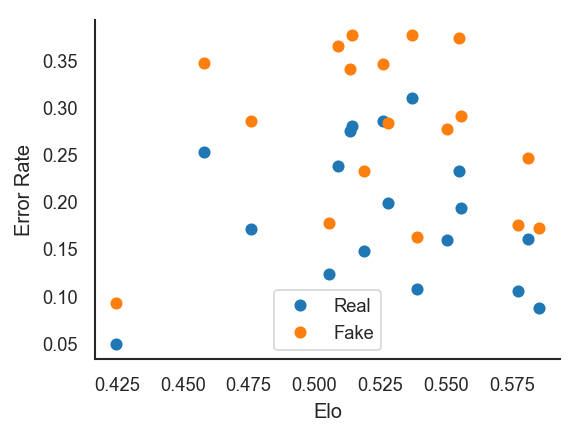

In [38]:
fig, axes  = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
axes.plot(mean_piv['x'], mean_piv[True], linestyle='none', marker='o', label='Real')
axes.plot(mean_piv['x'], mean_piv[False], linestyle='none', marker='o', label='Fake')
axes.legend(loc=0)


plt.setp(
    axes,
    xlabel='Elo', ylabel='Error Rate'
)

sns.despine()

In [70]:
d.subjects

array(['AB', 'AB2', 'CE', 'EN', 'EW', 'GB', 'GL', 'HS', 'IK', 'IS', 'JC',
       'JP', 'KL', 'LH', 'LM', 'LW', 'MS', 'OR', 'QC', 'SG', 'SL', 'SW',
       'TQ', 'VC', 'XG', 'XM', 'XW', 'XZ', 'YV', 'YZ'], dtype='<U3')